# Striatal dopamine dynamics - Fig. 4, DAT nanoclustering reduces uptake

Written by Aske Lykke Ejdrup<br>
Last updated: 2023/08/21

Code for the model presented in the manuscript:<br>
**Striatal dopamine dynamics and the regulation by the dopamine transporter** (unpublished)<br>
<font size = "2">By Aske L. Ejdrup<sup>1</sup>, Jakob K. Dreyer<sup>2</sup>, Matthew D. Lycas<sup>1</sup>, Søren H. Jørgensen<sup>1</sup>, Trevor W. Robbins<sup>3,4</sup>, Jeffrey W. Dalley<sup>3,4,5</sup>, Freja Herborg<sup>1</sup> and Ulrik Gether<sup>1</sup></font>

<br>


<font size = "2">
<sup>1</sup>Department of Neuroscience, Faculty of Health and Medical Sciences, Maersk Tower 7.5,
University of Copenhagen, Copenhagen, Denmark<br>
<sup>2</sup>Department of Bioinformatics, H Lundbeck A/S, Valby, Denmark<br>
<sup>3</sup>Behavioural and Clinical Neuroscience Institute, University of Cambridge, Cambridge CB2 3EB, UK<br>
<sup>4</sup>Department of Psychology, University of Cambridge, Cambridge CB2 3EB, UK<br>
<sup>5</sup>Department of Psychiatry, University of Cambridge, Cambridge CB2 0SZ, UK<br>
</font>

#### Import functions

In [4]:
# Functions
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as ss
from tqdm import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patheffects as pe

from cycler import cycler
custom_cycler = cycler(color=['#8B0000', '#FF0000', '#F08080', '#808080', '#000000'])

### DAT clustering simulation
<font color="red">(Skip to "Load pre-run simulations" to load our simulation results)<font>

Initally set to run at 20 nm voxel-size. Consider increasing during testing as run times can be exceedingly long 
<br>(but will affect validity of results below set simulations size).

#### Function to define the clusters

In [5]:
def create_clusters(matrix_size, num_circles, radii):
    # Initialize a list to hold the matrices for different radii
    matrices = []

    # Keep track of the centers
    centers = []

    # Randomly select centers for the circles
    for _ in range(num_circles):
        while True:
            # Randomly select the center for the circle
            max_radius = max(radii)
            center_x = np.random.randint(max_radius, matrix_size - max_radius)
            center_y = np.random.randint(max_radius, matrix_size - max_radius)

            # Check if the new circle overlaps with existing ones
            overlap = False
            for cx, cy in centers:
                if (center_x - cx)**2 + (center_y - cy)**2 < (2 * max_radius)**2:
                    overlap = True
                    break
            
            # If no overlap, break the loop and place the circle
            if not overlap:
                centers.append((center_x, center_y))
                break

    # Create a separate matrix for each radius
    for radius in radii:
        # Initialize a 2D matrix filled with zeros
        matrix = np.zeros((matrix_size, matrix_size))
        
        # Create circles at the same centers with the current radius
        for center_x, center_y in centers:
            for x in range(max(0, center_x - radius), min(matrix_size, center_x + radius)):
                for y in range(max(0, center_y - radius), min(matrix_size, center_y + radius)):
                    # Check if the current position is within the current radius
                    if (x - center_x)**2 + (y - center_y)**2 < radius**2:
                        matrix[x, y] = 1

        # Add the matrix for the current radius to the list
        matrices.append(matrix)

    return matrices

#### Functions to run the simulations

In [7]:
def do_timestep_3D(u0, space_DAT, DAT_mult, Vmax, Km):
    '''
    Function to calculate each timestep in the simulation.
    Calculates diffusion based on concentration input,
    them calculates uptakes and returns a new concentration matrix.
    
    Variables:
    u0 = matrix with concentrations represented in each voxel
    space_DAT = boolean matrix indicating which voxels have uptake capacity
    DAT_mult = scaling factor to ensure total uptake capacity of space remains the same
    Vmax = Average uptake capacity of the simulation space
    Km = DAT Km
    
    '''
    ##
    u = u0.copy()
    
    # Propagate with forward-difference in time, central-difference in space
    u = u0 + Ds * dt * (
        (np.roll(u0, 1, axis = 0) - \
         2*u0 + \
         np.roll(u0, -1, axis = 0))  /dx_dy**2 
              + \
        (np.roll(u0, 1, axis = 1) - \
         2*u0 + \
         np.roll(u0, -1, axis = 1))  /dx_dy**2
              + \
        (np.roll(u0, 1, axis = 2) - \
          2*u0 + \
          np.roll(u0, -1, axis = 2))  /dx_dy**2)
    
    
    # Simulate reuptake
    u = u - (dt*(Vmax*DAT_mult*u)/(Km + u))*space_DAT
    
    u0 = u.copy()
    return u0, u


def diffuse_3D_range(time, space0, space_ph, space_DAT, DAT_mult, Vmax, Km, Hz = 0.001):
    '''
    Function that runs the full simulation.
    Calculates number of timesteps to make based on dt (to remain stable)
    and runs through each step while saving only at Hz rate to minimize RAM requirements.
    
    Variables:
    time = durations of the simulation in seconds
    space0 = Empty matrix representing time and space to be populated with concentrations during simulation 
    spaceph = Matrix with concentrations represented in each voxel, representing the starting concentration
    space_DAT = boolean matrix indicating which voxels have uptake capacity
    DAT_mult = scaling factor to ensure total uptake capacity of space remains the same
    Vmax = Average uptake capacity of the simulation space
    Km = DAT Km
    Hz = Frequency of sampling (if too low the RAM requirements become very high)
    '''
    for i in tqdm(range(int(time/dt)-1)):
        # Apply gradient operator to simulate diffusion
        space_ph, u = do_timestep_3D(space_ph, space_DAT, DAT_mult, 
                                      Vmax, Km)
        
        # Save snapshot at specified Hz
        if i%int(Hz/dt) == 0:
            space0[int(i/(Hz/dt)+1),:,:,:] = space_ph
            
        
    return space0

#### Define simulation parameters and simulate cluster placements

In [9]:
# Start concentration
start_conc = 100*10**-9 # in molar

# Time parameters
time = 0.4 # Duration of simulation in sec
Hz = 0.001 # Sampling rate in sec

# Diffusivity of DA in striatum
D = 763 # um2.s-1
gamma = 1.54
Ds = D/(gamma**2)

# simulation size, um
w = h = 1.8
depth = 3.52 * 2

# intervals in x-, y- directions, um
dx = dy = dz = 0.05
dx_dy = dx
nx, ny, nz = int(w/dx), int(h/dy), int(depth/dz),

# Calculate timestep
dx2, dy2 = dx*dx, dy*dy
dt = dx2 * dy2 / (2 * D * (dx2 + dy2))

# Cluster parameters
num_clusters = 8   # Define the number of clusters
radii = [0.1,0.2]  # List of different radii to use
radii_conv = [round(x/dx) for x in radii] # convert to size for simulations

# Simulate DAT clusters
DAT_clusters = create_clusters(int(h/dx), num_clusters, radii_conv)


#### Run the simulations

In [10]:
sim_result_list = []

for i in range(len(radii)):
    
    # Create simulation space and supporting matrixes

    # Initiate the space
    space0 = np.zeros((round(time/Hz)+1, nx, ny, nz))

    # Initiate placeholder for the loop
    space_ph = np.zeros((nx, ny, nz))

    # set middle voxel to start_conc and correct for ECF
    space_ph[:] = start_conc

    # Project DAT clusters to the simulation space dimensions
    space_DAT = np.zeros((nx, ny, nz))
    space_DAT[:,:,-1] = DAT_clusters[i]

    # Calculate multiplier to convert avg. uptake capacity to cluster capactity density
    # based on cluster sizes (and therefore density of DAT molecules in the cluster)
    DAT_mult = (nx*ny*nz)/np.sum(space_DAT)
    
    sim_result = diffuse_3D_range(time, space0, space_ph, space_DAT, DAT_mult, Vmax = 4*10**-6, Km = 210*10**-9, Hz = Hz)
    
    np.save("sim_result_" + str(i), sim_result)
    
    sim_result_list.append(sim_result)

100%|██████████████████████████████████| 488318/488318 [11:23<00:00, 714.84it/s]


### Load pre-run simulations

In [2]:
# Load the data
sim_result_20 = np.load("data/sim_result_20.npy")
sim_result_40 = np.load("data/sim_result_40.npy")
sim_result_80 = np.load("data/sim_result_80.npy")
sim_result_160 = np.load("data/sim_result_160.npy")
sim_result_uni = np.load("data/sim_result_uni.npy")

### Calculate mean concentrations over time + time to 10 nM + difference between cluster and mean

In [ ]:
# Calculate the mean concentration over time of each simulation
mean_conc_sim = np.zeros((401,5))
mean_conc_sim[:,0] = np.mean(sim_result_20, axis = (1,2,3))
mean_conc_sim[:,1] = np.mean(sim_result_40, axis = (1,2,3))
mean_conc_sim[:,2] = np.mean(sim_result_80, axis = (1,2,3))
mean_conc_sim[:,3] = np.mean(sim_result_160, axis = (1,2,3))
mean_conc_sim[:,4] = np.mean(sim_result_uni, axis = (1,2,3))


# Relative time to 10 nm
t_rel_ten_nm = np.argmin(abs(mean_conc_sim*10**9 - 10),axis = 0)/np.argmin(abs(mean_conc_sim*10**9 - 10),axis = 0)[-1]

# Difference between center and mean
diff_conc_sim = np.zeros((401,4))
diff_conc_sim[:,0] = mean_conc_sim[:,0] - sim_result_20[:,45,28,-1]
diff_conc_sim[:,1] = mean_conc_sim[:,1] - sim_result_40[:,17,21,-1]
diff_conc_sim[:,2] = mean_conc_sim[:,2] - sim_result_80[:,17,21,-1]
diff_conc_sim[:,3] = mean_conc_sim[:,3] - sim_result_160[:,17,21,-1]

### Figure 4D, cross section on terminal surface

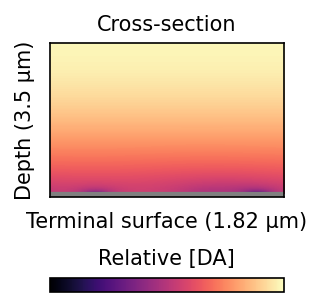

In [217]:
# Plot the cross section
fig, ax1 = plt.subplots(1,1,figsize = (2.5,3), dpi = 150)

b = ax1.imshow((sim_result_80[200,:,19,175:][:,::-1]*10**9).T, aspect = 0.33, cmap='magma', vmin = 5, vmax = 10)
ax1.plot([0,89], [-2,-2], color = "grey", lw = 3)
ax1.set_ylim(-4,175)
ax1.set_xlabel("Terminal surface (1.82 \u00B5m)", labelpad = 7)
ax1.set_ylabel("Depth (3.5 \u00B5m)", labelpad = 7)
ax1.set_title("Cross-section", fontsize = 10)

divider = make_axes_locatable(ax1)
cax = divider.append_axes("bottom", size="3%", pad=-0.5)
cbar = fig.colorbar(b, ax = ax1, cax = cax, orientation="horizontal", ticks=[])
cbar.set_label('Relative [DA]', labelpad=-21)

ax1.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    labelbottom=False,
    labelleft=False) # labels along the bottom edge are off

fig.tight_layout()

### Figure 4F, uptake by diameter cluster

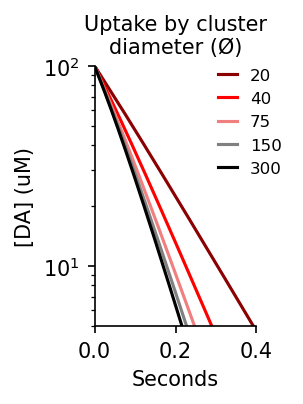

In [189]:
fig, ax1 = plt.subplots(1,1,figsize = (2.3,2.8), dpi = 150)

ax1.set_prop_cycle(custom_cycler)
ax1.plot(np.linspace(0,0.4,401),mean_conc_sim*10**9, lw = 1.5)
ax1.spines['top'].set_visible (False)
ax1.spines['right'].set_visible (False)
ax1.set_yscale("log")
ax1.set_ylim(5, 100)
ax1.set_xlim(0, 0.4)
ax1.set_xlabel("Seconds")
ax1.set_ylabel("[DA] (uM)")
ax1.set_title("Uptake by cluster\ndiameter (Ø)", fontsize = 10)
ax1.legend(("20","40","75","150","300", "Un."), title_fontsize = 8,
           loc = "upper right",frameon = False, prop={'size': 8}, bbox_to_anchor =[1.25,1.05],
           handlelength = 1.1)
ax1.plot([0,0.4], [0.01,0.01], color = "k", lw = 0.8, ls = "--", zorder = 0)

fig.tight_layout()

### Figure 4G, time to 10 nM

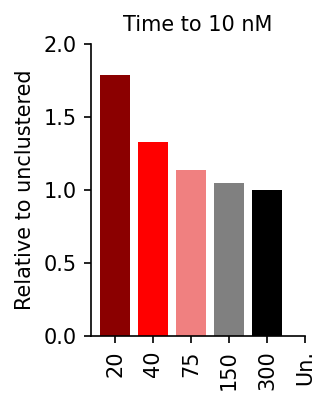

In [190]:
fig, ax1 = plt.subplots(1,1,figsize = (2.3,2.8), dpi = 150)

ax1.set_title("Time to 10 nM", fontsize = 10)
ax1.bar([0,1,2,3,4], t_rel_ten_nm
        , color = ['#8B0000', '#FF0000', '#F08080', '#808080', '#000000'])
ax1.set_ylim(0,2)
# ax1.set_yticks([0.5,0.75,1,1.25,1.5])
ax1.set_ylabel("Relative to unclustered")

# ax2.set_xticks([])
ax1.set_xticks([0,1,2,3,4,5])
ax1.set_xticklabels(["20","40","75","150","300","Un."], rotation = 90)
# ax2.set_xlabel("Cluster size, Ø (nm)")
# ax2.spines["bottom"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)

fig.tight_layout()

### Figure 4H, [DA] drop at center of cluster

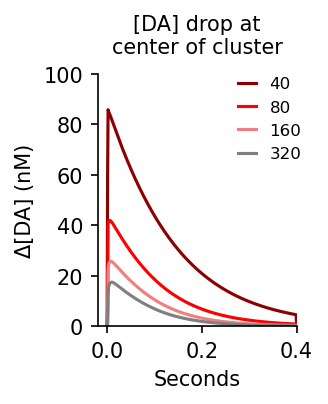

In [194]:
fig, ax1 = plt.subplots(1,1,figsize = (2.3,2.8), dpi = 150)

ax1.set_prop_cycle(custom_cycler)
ax1.plot(np.linspace(0,0.4,401), diff_conc_sim*10**9)
# ax1.set_title("Difference between\ncluster and average [DA]", fontsize = 10, pad = 10)
ax1.set_title("[DA] drop at\ncenter of cluster", fontsize = 10, pad = 10)
ax1.set_ylim(0,100)
ax1.set_ylabel("\u0394[DA] (nM)")
ax1.set_xlim(-0.02,0.4)
ax1.set_xticks([0,0.2,0.4])
ax1.set_xlabel("Seconds")
ax1.legend(("40","80","160","320"), title_fontsize = 8,
           loc = "upper right",frameon = False, prop={'size': 8}, bbox_to_anchor =[1.1,1.05],
           handlelength = 1.1)

ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)

fig.tight_layout()

### Figure 4I, [DA] drop for 150 nm clusters

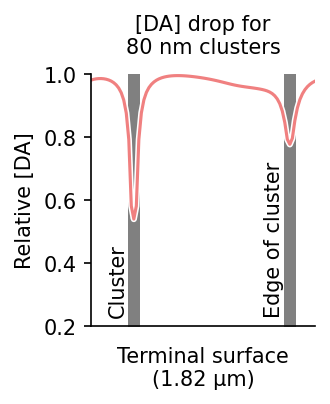

In [195]:
fig, ax1 = plt.subplots(1,1,figsize = (2.3,2.8), dpi = 150)

ax1.set_title("[DA] drop for\n80 nm clusters", fontsize = 10, pad = 10)
ax1.plot(sim_result_40[-10,:,21,-1]/np.max(sim_result_40[-10,:,21,-1])-0.005, color = '#F08080',
         path_effects=[pe.Stroke(linewidth=3, foreground='w'), pe.Normal()])
ax1.fill_between([17-2.5,17+2.5],[1,1], color = "grey", alpha = 1, lw = 0, zorder = 0)
ax1.text(14.5,0.23,"Cluster", rotation = 90, ha = "right", va = "bottom")
ax1.fill_between([79-2.5,79+2.5],[1,1], color = "grey", alpha = 1, lw = 0, zorder = 0)
ax1.text(76.5,0.23,"Edge of cluster", rotation = 90, ha = "right", va = "bottom")
ax1.set_ylim(0.2,1)
ax1.set_ylabel("Relative [DA]")
ax1.set_xlim(0,89)
ax1.set_xticks([])
ax1.set_xlabel("Terminal surface\n(1.82 \u00B5m)", labelpad = 9.5)
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)

fig.tight_layout()